---
# <center> Small data: weak supervision, transfer, and incorporation of priors

<center> Eya Ghamgui $~~$ eya.ghamgui@telecom-paris.fr
<center> Siwar Mhadhbi $~~$ siwar.mhadhbi@telecom-paris.fr
<center> Saifeddine Barkia $~~$ saifeddine.barkia@telecom-paris.fr
<center> March 10, 2022

---

# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [2]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

**Answer 1:**

In [ ]:
# Loading train data set
all_trainset = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True , transform=transforms.ToTensor())
first_100 = torch.utils.data.Subset(all_trainset, list(np.arange(100))) 
train_loader  = torch.utils.data.DataLoader(first_100)

# Loading test data set
all_testset = torchvision.datasets.CIFAR10(root ="\content", train=False , download=True)
test_loader = torch.utils.data.DataLoader(all_testset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting \content/cifar-10-python.tar.gz to \content
Files already downloaded and verified


## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

**Answer 2:**

> The evaluation of the training procedure is difficult because: 
<br><br>
**Problem 1:** <br> We have a small training dataset compared to the test dataset. Indeed, we have selected only $100$ samples out of $50000$ training images. Thus, we may have an imbalance of classes (some classes are not well represented compared to others). We may also, in the extreme case, have omitted one class from the training dataset so that the corresponding samples in the test dataset will all be wrongly labeled) but the latter is not in our case.

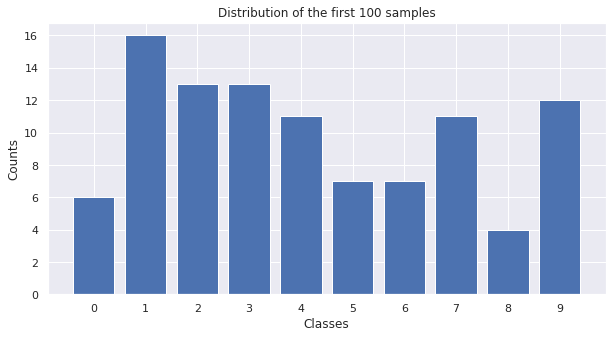

In [ ]:
# Visualization of the distribution of the first 100 samples
l=[]
for data,target in train_loader:
  l.append(target.item())
counts = np.unique(np.array(l),return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(counts[0],counts[1])
plt.xlabel('Classes')
plt.xticks(counts[0])
plt.ylabel('Counts')
plt.title('Distribution of the first 100 samples');


>  **Solution** : <br>
  * We have to select specific data samples with reasonable proportions so that we have a good representaion of the $10$ classes that are present in the CIFAR-10 data set.
  * We can perform resampling on data to overcome the problem of class imbalance by downsamppling (eg. RandomUnderSampler) or/and oversampling (eg. RandomOverSampler, Bootstrap, SMOTE, etc) which can be found implemented in [imbalanced-learn library](https://imbalanced-learn.org/stable/references/index.html#api).

> **Problem 2:** <br> Overfitting is more likely to occur when we train on a small data set. Therefore, we will perform poorly on the test dataset. <br> **Solution**:
  * We can perform data augmentation. 
  * We can also consider using some weak supervision techniques as we have seen in class (sem-supervised, self-supervised) to label some of the unlableled data set $\mathcal{X}_{\text{nolabel}}$ and add them to the train dataset. (Tried in the bonus part).

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

**Answer 3:**

In [ ]:
# --- The following code is taken from the official Pytorch implementation 
# --- Source : https://github.com/kuangliu/pytorch-cifar.

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [3]:
# Function to plot training accuracy and training loss over epochs 

def show(train_accuracy, training_loss):
  fig, ax = plt.subplots(1,2 , figsize=(15,5))

  ax[0].plot(np.arange(len(train_accuracy)), train_accuracy)
  ax[0].set_title('Training Accuracy')
  ax[0].set_xlabel('epochs')

  ax[1].plot(np.arange(len(training_loss)), training_loss)
  ax[1].set_title('Training Loss')
  ax[1].set_xlabel('epochs')

  plt.show()

In [4]:
def train(model, epochs, optimizer, scheduler, criterion, train_loader, verbose=True, device=device , start_epoch=0):

  '''
  Function to train the model
  '''
  
  model = model.to(device)

  training_loss = []
  train_accuracy = []
  for epoch in range(start_epoch, epochs+start_epoch): 

    # Set model to training mode
    model.train()

    epoch_train_loss = 0
    epoch_total_samples = 0
    epoch_number_correct = 0   

    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        predicted_batch = output.argmax(dim=1)
        epoch_total_samples += len(target) 
        epoch_number_correct += (predicted_batch == target).sum()

    epoch_accuracy = 100 * (epoch_number_correct /epoch_total_samples )
    train_accuracy.append(epoch_accuracy.item())
    average_epochloss = epoch_train_loss/len(train_loader)
    training_loss.append(average_epochloss)

    if verbose :
      if epoch % 5 == 0  or epoch == epochs+start_epoch - 1 : 
        print('Train Epoch: {} : Loss : {:.4f} / Accuracy : {:.4f} %'.format(epoch, average_epochloss,epoch_accuracy))
        
  return train_accuracy , training_loss 

In [5]:
def test (model, criterion, device, test_loader,verbose=True):

  '''
  Function to test the model
  '''

  # Set model to evaluation mode
  model.eval()
  
  with torch.no_grad():

      test_loss = 0
      correct_predictions = 0
      number_samples = 0
      
      for batch_idx, (data, target) in enumerate(test_loader):

          data, target = data.to(device), target.to(device)
          output = model(data)

          loss = criterion(output, target)
          test_loss += loss.item()
          predicted_batch = output.argmax(dim=1)
          correct_predictions+= (predicted_batch == target).sum()
          number_samples += len(target)

      final_loss = test_loss/len(test_loader)
      final_accuracy = 100 * (correct_predictions/number_samples)
      if verbose :
        print('Test Results :  Loss : {} / Accuracy : {} %'.format(
          final_loss,final_accuracy,))
          
  return  final_accuracy

Files already downloaded and verified
Files already downloaded and verified
____________________________
Train phase
Train Epoch: 0 : Loss : 2.4047 / Accuracy : 12.0000 %
Train Epoch: 5 : Loss : 0.2195 / Accuracy : 99.0000 %
Train Epoch: 10 : Loss : 0.1007 / Accuracy : 100.0000 %
Train Epoch: 15 : Loss : 0.1007 / Accuracy : 99.0000 %
Train Epoch: 19 : Loss : 0.0901 / Accuracy : 99.0000 %


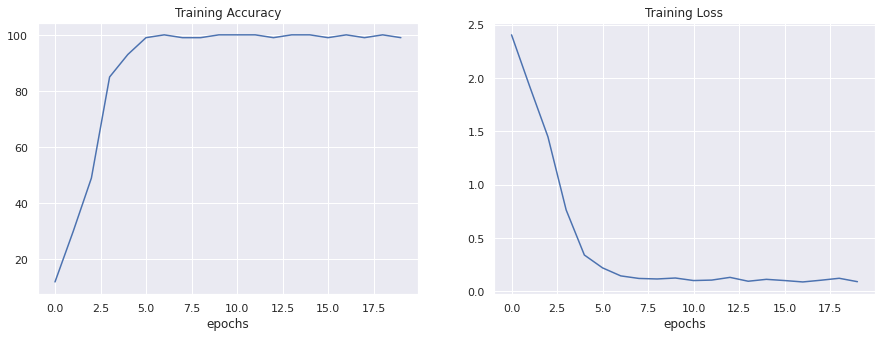

____________________________
Test phase
Test Results :  Loss : 2.3738846037387846 / Accuracy : 23.920000076293945 %


In [ ]:
# Hyperparameters
epochs = 20
batch_size = 20

# Loading train data set
all_trainset = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True , transform=transforms.ToTensor())
first_100= torch.utils.data.Subset(all_trainset, list(np.arange(100)) ) 
train_loader  = torch.utils.data.DataLoader(first_100, batch_size=batch_size, shuffle=True)

# Loading test data set
all_testset = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(all_testset, batch_size=batch_size, shuffle=False)

# Model and its components 
model = ResNet18()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

print("____________________________")
print("Train phase")
train_accuracy , training_loss = train(model, epochs, optimizer, scheduler, criterion, train_loader)
show(train_accuracy, training_loss)
print("____________________________")
print("Test phase")
test_accuracy = test(model, criterion, device, test_loader)

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Resnet18  | 20 | 99% | 23.92% |


<br>
Resources for models performance on the entire CIFAR-10:
<br>



|Link | Model | Number of  epochs  | Train accuracy | Test accuracy |
|------ |------|------|------|------|
|[Github](https://github.com/abhisikdar/RESNET18-CIFAR10/blob/main/Part_1.ipynbf)|   Resnet18  | 150 | 100% | 75.98% |
[Github](https://github.com/rashutyagi/ResNet18-on-CIFAR-10)|   Resnet18  | 40 | 91.46% | 86.31% |
[[Cascante-Bonilla, et al.]](https://arxiv.org/pdf/2001.06001.pdf)|   Resnet18  | 750 | - | 94.91% |








# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

**Answer 4:**
>  In this part, we tried three different pretrained models (ResNet-18, ResNet-34 and ResNet-50) as baseline models. In addition, we added two fully connected layers. We chose for training a batch size equal to $10$ and the SGD optimizer with a learning rate equal to $10^{-3}$ and a momentum of $0.9$. 
  * The training is divided into three stages. In a first step, we freezed the entire layers and we only fine-tuned the two added layers. Next, we froze only the first half of layers and re-trained the model on the second half. Finally, the model is re-trained on all unfreezed layers. We chose as number of epochs $15\times 3$, $25 \times 3$ and $30 \times 3$ for each model respectively. As a first part, the model is trained using the original images. Then, we resized the images to ($224 \times 224$) which gave much better performance for the $3$ pretrained models.
<br>
  * From the plots of training loss and training accuracy, we observe a peculiar learning behavior. In the first two stages, the accuracy curve keeps increasing over epochs. In the last part, we can observe a drop in values, then a further increase. 
<br>
  * From the previous results, we can notice that all the pre-trained models have close performances, with only a small advantage for ResNet-34. This result can perhaps be explained by the fact that the model is more complicated than ResNet-18 and is therefore able to learn better details, but not too complicated like ResNet-50 which is not efficient in our case. 
  * The following table reports training and testing accuracies:

| Model | Number of  epochs  | Train accuracy <br> (w/o resizing)| Train accuracy <br> (w/ resizing) | Test accuracy <br> (w/o resizing) | Test accuracy<br> (w/ resizing)|
|------|------|------|------|------|------|
|   Pretrained Resnet-18  | <center> 45 </center> | <center>95% <center>| <center>100% <center>|<center>29.44%<center>| <center>58.34% <center>|
|   **Pretrained Resnet-34**  |  <center> **60** </center> | <center>**93%**<center> | <center>**100%**<center> |<center>**33.22%**<center>| <center>**63.11%** <center>|
|   Pretrained Resnet-50  |  <center> 90 </center> | <center>93% <center>| <center>100%<center> |<center>30.57% <center>| <center>61.08% <center>|

In [6]:
class Net(nn.Module):

    def __init__(self,type_model = 'ResNet18'):
        super().__init__()

        # Baseline model
        if type_model == 'ResNet18':
          self.model = models.resnet18(pretrained=True)
        elif type_model == 'ResNet34':
          self.model = models.resnet34(pretrained=True)
        elif type_model == 'ResNet50':
          self.model = models.resnet50(pretrained=True)

        self.num_filters = self.model.fc.in_features
        self.layers = list(self.model.children())[:-1]
        self.backbone = nn.Sequential(*self.layers)

        # Added fully connected layers 
        self.fc1 = nn.Linear(self.num_filters, 64) 
        self.fc = nn.Linear(64, 10)  

    def forward(self, x):

      x = self.backbone(x)
      x = x.squeeze(3)
      x = x.squeeze(2)
      x = self.fc1(x)
      x = self.fc(x)

      return x

In [7]:
def training(type_model, epochs, train_loader, test_loader, lr=1e-3, momentum=0.9, plot=True) : 

  print('-' , type_model,end='\n') 
  model = Net(type_model)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

  print("____________________________")
  print("Train phase")

  # ----------------- Fine-tune only the last layer of the architecture ------------------ #

  for param in model.parameters():
    param.requires_grad = False

  for param in model.fc.parameters():
    param.requires_grad = True
  
  for param in model.fc1.parameters():
    param.requires_grad = True
  
  train_accuracy , training_loss = train(model,epochs,optimizer, scheduler, criterion,train_loader, start_epoch = 0)
  
  # ----------------- Fine-tune the second half of the architecture ---------------------- #

  for param in model.parameters():
    param.requires_grad = True

  child_nbrs = 0
  for child in model.children():
    child_nbrs += 1

  child_counter = 0
  for child in model.children():
    if child_counter < child_nbrs//2 :
        child_counter += 1
        for param in child.parameters():
            param.requires_grad = False
  
  for param in model.fc.parameters():
    param.requires_grad = True

  for param in model.fc1.parameters():
    param.requires_grad = True
  
  train_accuracy1 , training_loss1 = train(model,epochs,optimizer,scheduler,criterion,train_loader,  start_epoch = epochs) 

  # ----------------------- Fine-tune the whole architecture ---------------------------- #

  for param in model.parameters():
    param.requires_grad = True 
  train_accuracy2 , training_loss2 = train(model,epochs,optimizer,scheduler,criterion,train_loader,  start_epoch = 2*epochs) 

  if plot : 
    show(train_accuracy+train_accuracy1+train_accuracy2 , training_loss+training_loss1+training_loss2) 

  print("____________________________")
  print("Test phase")
  test_accuracy = test(model, criterion, device, test_loader)

## **1. Without resizing images:**

In [ ]:
batch_size = 10

# Loading train data set
all_trainset = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True , transform=transforms.ToTensor())
first_100= torch.utils.data.Subset(all_trainset, list(np.arange(100)) ) 
train_loader  = torch.utils.data.DataLoader(first_100, batch_size=batch_size, shuffle=True)

# Loading test data set
all_testset = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(all_testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#### **Pretrained Resnet-18 model**

- ResNet18
____________________________
Train phase
Train Epoch: 0 : Loss : 2.3905 / Accuracy : 4.0000 %
Train Epoch: 5 : Loss : 1.9399 / Accuracy : 33.0000 %
Train Epoch: 10 : Loss : 1.6692 / Accuracy : 44.0000 %
Train Epoch: 14 : Loss : 1.3529 / Accuracy : 55.0000 %
Train Epoch: 15 : Loss : 1.3597 / Accuracy : 54.0000 %
Train Epoch: 20 : Loss : 1.2087 / Accuracy : 65.0000 %
Train Epoch: 25 : Loss : 1.1320 / Accuracy : 68.0000 %
Train Epoch: 29 : Loss : 0.9800 / Accuracy : 70.0000 %
Train Epoch: 30 : Loss : 0.9236 / Accuracy : 80.0000 %
Train Epoch: 35 : Loss : 0.5013 / Accuracy : 82.0000 %
Train Epoch: 40 : Loss : 0.2565 / Accuracy : 93.0000 %
Train Epoch: 44 : Loss : 0.1855 / Accuracy : 95.0000 %


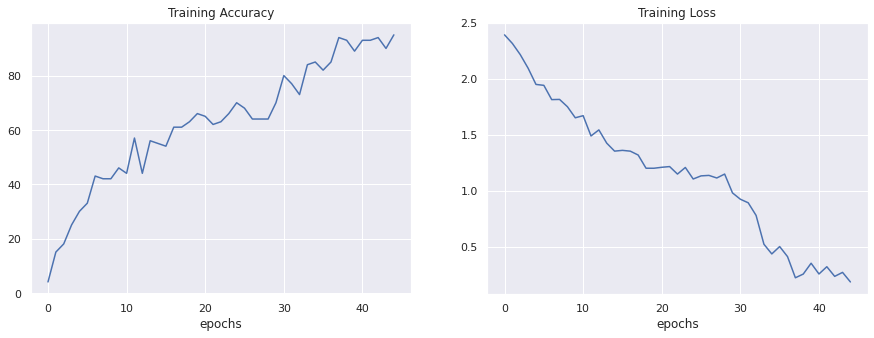

____________________________
Test phase
Test Results :  Loss : 2.904219800770283 / Accuracy : 29.440000534057617 %


In [ ]:
training('ResNet18', epochs=15, train_loader=train_loader, test_loader=test_loader)

#### **Pretrained Resnet-34 model**

- ResNet34
____________________________
Train phase
Train Epoch: 0 : Loss : 2.3948 / Accuracy : 9.0000 %
Train Epoch: 5 : Loss : 1.8890 / Accuracy : 40.0000 %
Train Epoch: 10 : Loss : 1.5008 / Accuracy : 53.0000 %
Train Epoch: 15 : Loss : 1.3018 / Accuracy : 62.0000 %
Train Epoch: 19 : Loss : 1.2292 / Accuracy : 65.0000 %
Train Epoch: 20 : Loss : 1.1207 / Accuracy : 67.0000 %
Train Epoch: 25 : Loss : 1.0377 / Accuracy : 72.0000 %
Train Epoch: 30 : Loss : 0.8918 / Accuracy : 78.0000 %
Train Epoch: 35 : Loss : 0.8462 / Accuracy : 75.0000 %
Train Epoch: 39 : Loss : 0.7759 / Accuracy : 75.0000 %
Train Epoch: 40 : Loss : 0.8134 / Accuracy : 74.0000 %
Train Epoch: 45 : Loss : 0.7633 / Accuracy : 80.0000 %
Train Epoch: 50 : Loss : 0.2597 / Accuracy : 95.0000 %
Train Epoch: 55 : Loss : 0.4683 / Accuracy : 92.0000 %
Train Epoch: 59 : Loss : 0.1582 / Accuracy : 93.0000 %


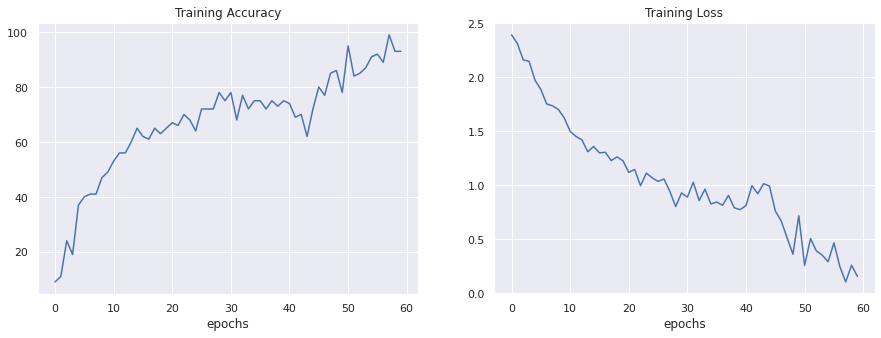

____________________________
Test phase
Test Results :  Loss : 2.807661985874176 / Accuracy : 32.220001220703125 %


In [ ]:
training('ResNet34', epochs=20, train_loader=train_loader, test_loader=test_loader)

#### **Pretrained Resnet-50 model**

- ResNet50
____________________________
Train phase
Train Epoch: 0 : Loss : 2.2872 / Accuracy : 11.0000 %
Train Epoch: 5 : Loss : 1.9964 / Accuracy : 43.0000 %
Train Epoch: 10 : Loss : 1.7035 / Accuracy : 53.0000 %
Train Epoch: 15 : Loss : 1.5325 / Accuracy : 55.0000 %
Train Epoch: 20 : Loss : 1.2650 / Accuracy : 60.0000 %
Train Epoch: 25 : Loss : 1.0976 / Accuracy : 69.0000 %
Train Epoch: 29 : Loss : 0.9906 / Accuracy : 76.0000 %
Train Epoch: 30 : Loss : 1.0787 / Accuracy : 65.0000 %
Train Epoch: 35 : Loss : 0.9557 / Accuracy : 73.0000 %
Train Epoch: 40 : Loss : 0.9112 / Accuracy : 72.0000 %
Train Epoch: 45 : Loss : 0.7857 / Accuracy : 77.0000 %
Train Epoch: 50 : Loss : 0.7061 / Accuracy : 81.0000 %
Train Epoch: 55 : Loss : 0.6474 / Accuracy : 82.0000 %
Train Epoch: 59 : Loss : 0.7618 / Accuracy : 77.0000 %
Train Epoch: 60 : Loss : 0.9892 / Accuracy : 68.0000 %
Train Epoch: 65 : Loss : 0.7875 / Accuracy : 75.0000 %
Train Epoch: 70 : Loss : 0.1738 / Accuracy : 93.0000 %
Train Epoch: 75

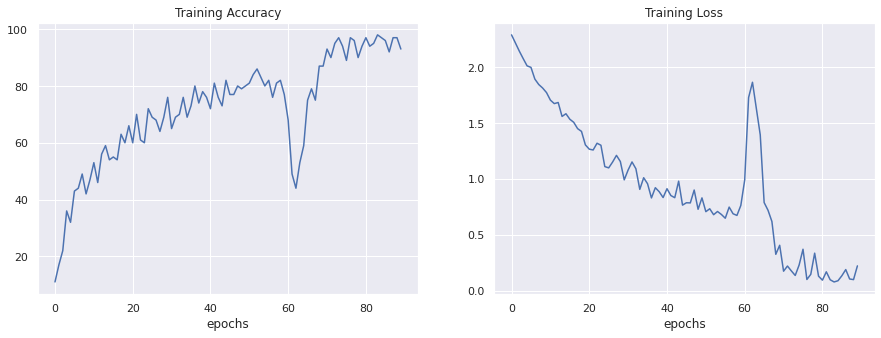

____________________________
Test phase
Test Results :  Loss : 2.7967134895324706 / Accuracy : 30.56999969482422 %


In [ ]:
training('ResNet50', epochs=30, train_loader=train_loader, test_loader=test_loader)

## **2. With resizing images:**

In [ ]:
batch_size = 10

# Resize images
transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor()
                ])

# Loading train data set
all_trainset = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True , transform=transform)
first_100= torch.utils.data.Subset(all_trainset, list(np.arange(100)) ) 
train_loader  = torch.utils.data.DataLoader(first_100, batch_size=batch_size, shuffle=True)

# Loading test data set
all_testset = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(all_testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#### **Pretrained Resnet-18 model**

- ResNet18
____________________________
Train phase
Train Epoch: 0 : Loss : 2.2777 / Accuracy : 12.0000 %
Train Epoch: 5 : Loss : 1.8047 / Accuracy : 50.0000 %
Train Epoch: 10 : Loss : 1.3551 / Accuracy : 74.0000 %
Train Epoch: 14 : Loss : 1.1547 / Accuracy : 78.0000 %
Train Epoch: 15 : Loss : 1.0474 / Accuracy : 84.0000 %
Train Epoch: 20 : Loss : 0.8189 / Accuracy : 91.0000 %
Train Epoch: 25 : Loss : 0.6497 / Accuracy : 95.0000 %
Train Epoch: 29 : Loss : 0.5964 / Accuracy : 94.0000 %
Train Epoch: 30 : Loss : 0.5193 / Accuracy : 97.0000 %
Train Epoch: 35 : Loss : 0.1014 / Accuracy : 100.0000 %
Train Epoch: 40 : Loss : 0.0528 / Accuracy : 100.0000 %
Train Epoch: 44 : Loss : 0.0254 / Accuracy : 100.0000 %


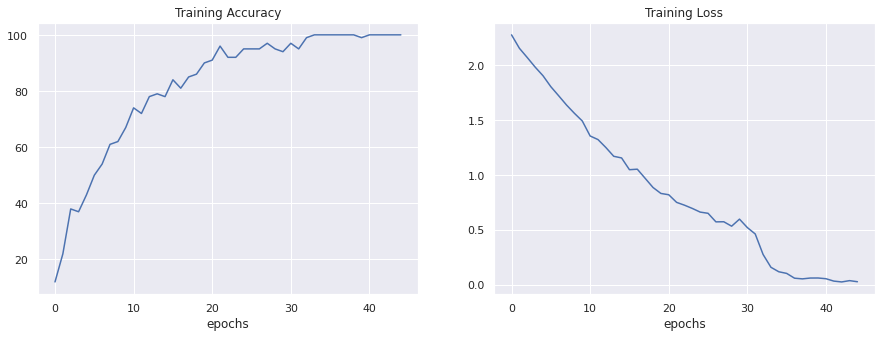

____________________________
Test phase
Test Results :  Loss : 1.1663681173622609 / Accuracy : 58.39999771118164 %


In [ ]:
training('ResNet18', epochs=15, train_loader=train_loader, test_loader=test_loader)

#### **Pretrained Resnet-34 model**

- ResNet34
____________________________
Train phase
Train Epoch: 0 : Loss : 2.3046 / Accuracy : 10.0000 %
Train Epoch: 5 : Loss : 1.8065 / Accuracy : 54.0000 %
Train Epoch: 10 : Loss : 1.3849 / Accuracy : 70.0000 %
Train Epoch: 15 : Loss : 0.9546 / Accuracy : 88.0000 %
Train Epoch: 19 : Loss : 0.7795 / Accuracy : 92.0000 %
Train Epoch: 20 : Loss : 0.7414 / Accuracy : 93.0000 %
Train Epoch: 25 : Loss : 0.5493 / Accuracy : 95.0000 %
Train Epoch: 30 : Loss : 0.4251 / Accuracy : 100.0000 %
Train Epoch: 35 : Loss : 0.3284 / Accuracy : 99.0000 %
Train Epoch: 39 : Loss : 0.3190 / Accuracy : 97.0000 %
Train Epoch: 40 : Loss : 0.3026 / Accuracy : 97.0000 %
Train Epoch: 45 : Loss : 0.0539 / Accuracy : 100.0000 %
Train Epoch: 50 : Loss : 0.0164 / Accuracy : 100.0000 %
Train Epoch: 55 : Loss : 0.0112 / Accuracy : 100.0000 %
Train Epoch: 59 : Loss : 0.0095 / Accuracy : 100.0000 %


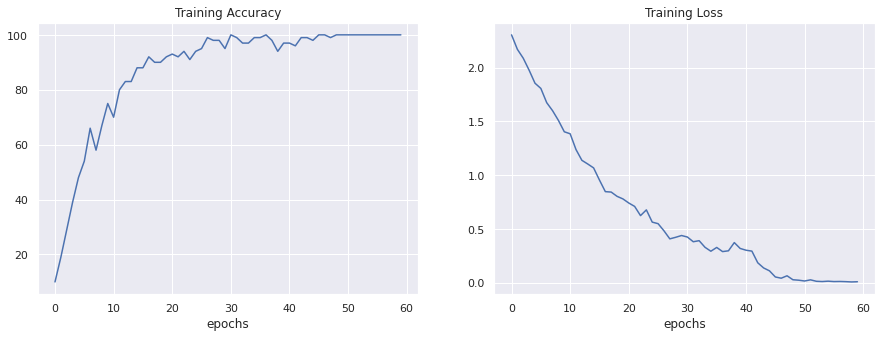

____________________________
Test phase
Test Results :  Loss : 1.0815703084766866 / Accuracy : 63.11000061035156 %


In [ ]:
training('ResNet34', epochs=20, train_loader=train_loader, test_loader=test_loader)

#### **Pretrained Resnet-50 model**

- ResNet50
____________________________
Train phase
Train Epoch: 0 : Loss : 2.3212 / Accuracy : 9.0000 %
Train Epoch: 5 : Loss : 1.8958 / Accuracy : 43.0000 %
Train Epoch: 10 : Loss : 1.5374 / Accuracy : 66.0000 %
Train Epoch: 15 : Loss : 1.2122 / Accuracy : 74.0000 %
Train Epoch: 20 : Loss : 1.0494 / Accuracy : 75.0000 %
Train Epoch: 24 : Loss : 0.9128 / Accuracy : 88.0000 %
Train Epoch: 25 : Loss : 0.7647 / Accuracy : 88.0000 %
Train Epoch: 30 : Loss : 0.6385 / Accuracy : 94.0000 %
Train Epoch: 35 : Loss : 0.5141 / Accuracy : 96.0000 %
Train Epoch: 40 : Loss : 0.3995 / Accuracy : 98.0000 %
Train Epoch: 45 : Loss : 0.3503 / Accuracy : 99.0000 %
Train Epoch: 49 : Loss : 0.2926 / Accuracy : 98.0000 %
Train Epoch: 50 : Loss : 0.3254 / Accuracy : 94.0000 %
Train Epoch: 55 : Loss : 0.0616 / Accuracy : 100.0000 %
Train Epoch: 60 : Loss : 0.0414 / Accuracy : 100.0000 %
Train Epoch: 65 : Loss : 0.0141 / Accuracy : 100.0000 %
Train Epoch: 70 : Loss : 0.0130 / Accuracy : 100.0000 %
Train Epoch:

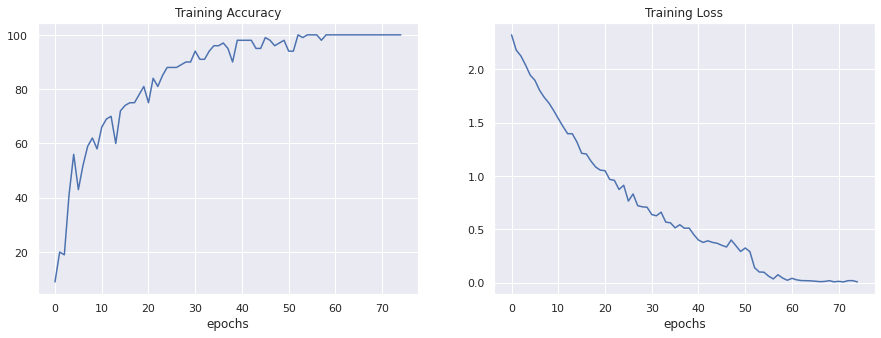

____________________________
Test phase
Test Results :  Loss : 1.117826816931367 / Accuracy : 61.07999801635742 %


In [ ]:
training('ResNet50', epochs=25, train_loader=train_loader, test_loader=test_loader)

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

**Answer 5:**

* *Translation:* 
  * **Problem:** When we perform translation on an image, translated pixels are replaced by black ones. So, given a finite support of the image, part of the information is lost because pixels mapped to points outside the boundaries are ignored.

  * **Solution:** We can wrap ignored pixels around the edges, so that all the intensity information is retained.


* *Rotation:*
  * **Problem:**
  When we apply a rotation $(\theta \neq k \pi)$, the values of the pixels around the corners won't lay in the grid defined by the input image, which can lead to a lot of voids. 

  * **Solution:** To tackle this problem, we can apply many forms of interpolations such as: Linear interpolation, Bilinear interpolation, Cubic interpolation, etc.

* *Scaling effects:*
  * **Problem:** One of the main problems with scaling is that the image becomes blurry and distorted, resulting in a loss of information. Scaling an image beyond its original dimensions can result in a very fuzzy and pixelated image. In addition, the downsampling can cause aliasing arteficats. 

  * **Solution:** To solve the previous issues, we may apply also interpolation techniques. Moreover, in the case of downsampling, an anti-aliasing filter can be applied. And in the case of upsampling, a reconstruction filter takes the place of the anti-aliasing filter.

* *Color changes:*
  * **Problem:** When we apply color changes on an RGB image, it affects not only color information but also intensity information and thus results in an image with very strange colors. This can be explained by the fact that RGB channels tend to exhibit high levels of correlation.

  * **Solution:** To avoid this problem, we can convert images from RGB space to another colorspace such as HSV since it separates the image intensity from the color information. So that changes are applied only on the intensity component. <br> In computer vision we often want to separate color components from intensity for various reasons, such as robustness to lighting changes, or removing shadows.



## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

**Answer 6:**

> In this part, we augmented the 100-sample dataset by applying a set of geometric transformations. These latter will randomly augment our images so that the model gets to see different samples for every iteration. <br>
In our pipeline, we chose to incorporate the following transformations combined using `torchvision.transforms.Compose()` :
<br>
- Horizontally flip the given image randomly with probability $\frac{1}{2}$. This transformation alone improved very well the performance of our models. `RandomHorizontalFlip()`
- Randomly crop the input image. `RandomCrop(size=[32,32], padding=3)`
- Blur image with randomly chosen Gaussian blur with kernel $3\times3$. `GaussianBlur(kernel_size=(3,3))`
- Randomly change the hue of an image with probability $0.1$ while preserving its brightness, contrast, and saturation. `ColorJitter(hue=.1)`

> Applying this pipeline of data augmentation improved the accuracy of all the tried models up to $3.4\%$.
* For the ResNet-18, we improved its accuracy on the test set from $23.92\%$ to $25.87\%$.
* The best accuracy obtained is of $34.57\%$ with Pretrained ResNet-50 model.
* We report below the accuracies of all tried models w/ and w/o data augmentation:

| Model | Number of  epochs <br>(w/o data augmentation)| Number of  epochs <br>(w/ data augmentation) | Train accuracy <br>(w/o data augmentation) |Train accuracy <br>(w/ data augmentation) || Test accuracy <br>(w/o data augmentation) | Test accuracy <br>(w/ data augmentation)|
|------|------|------|------|------||------|------|
|   Resnet-18  | <center> 20 </center>| <center> 40 </center> | <center>99% <center>|<center>96% <center>|| <center>23.92% <center>|<center>**25.87%** <center>|
|   Pretrained Resnet-18  | <center> 45 </center>|  <center> 60 </center> | <center>95%<center> |<center>87% <center>|| <center>30.97%<center> | <center>**31.96%**<center> |
|   Pretrained Resnet-34 | <center> 75 </center>|  <center> 75 </center> | <center>94% <center>|<center>94% <center>|| <center>30.29%<center> |<center>**32.04%**<center> |
|   **Pretrained Resnet-50**  | <center> 90 </center>|  <center> 99 </center> |<center>99% <center>| <center>96% <center>|| <center>31.14%<center> |<center>**34.57%**<center> |






In [ ]:
batch_size= 20

# Data transformations
train_transformations = transforms.Compose([
                 transforms.RandomHorizontalFlip(),
                 transforms.RandomCrop(size=[32,32], padding=3),
                 transforms.GaussianBlur(kernel_size=(3,3)),
                 transforms.ColorJitter(hue=.1),
                 transforms.ToTensor(),
                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                 ])

test_transformations = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                 ])

# Loading train data set
all_trainset = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True , transform=train_transformations)
first_100= torch.utils.data.Subset(all_trainset, list(np.arange(100)) ) 
train_loader  = torch.utils.data.DataLoader(first_100, batch_size=batch_size, shuffle=True)

# Loading test data set
all_testset = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=test_transformations)
test_loader = torch.utils.data.DataLoader(all_testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#### **ResNet-18 with data augmentation**

In [ ]:
# Hyperparameters
epochs = 40

# Model and its components 
model = ResNet18()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

print("____________________________")
print("Train phase")
train_accuracy , training_loss = train(model, epochs, optimizer, scheduler, criterion, train_loader)
print("____________________________")
print("Test phase")
test_accuracy = test(model, criterion, device, test_loader)

____________________________
Train phase
Train Epoch: 0 : Loss : 2.3086 / Accuracy : 14.0000 %
Train Epoch: 5 : Loss : 1.7538 / Accuracy : 38.0000 %
Train Epoch: 10 : Loss : 1.2889 / Accuracy : 54.0000 %
Train Epoch: 15 : Loss : 0.8870 / Accuracy : 72.0000 %
Train Epoch: 20 : Loss : 0.6118 / Accuracy : 81.0000 %
Train Epoch: 25 : Loss : 0.5645 / Accuracy : 81.0000 %
Train Epoch: 30 : Loss : 0.7011 / Accuracy : 80.0000 %
Train Epoch: 35 : Loss : 0.1432 / Accuracy : 97.0000 %
Train Epoch: 39 : Loss : 0.1319 / Accuracy : 96.0000 %
____________________________
Test phase
Test Results :  Loss : 4.2356440534591675 / Accuracy : 25.869998931884766 %


---

#### **Pretrained models with data augmentation**

In [ ]:
# Loading train data set
all_trainset = torchvision.datasets.CIFAR10(root ="\content", train=True, download=True , transform=train_transformations)
first_100= torch.utils.data.Subset(all_trainset, list(np.arange(100)) ) 
train_loader  = torch.utils.data.DataLoader(first_100, batch_size=batch_size, shuffle=True)

# Loading test data set
all_testset = torchvision.datasets.CIFAR10(root ="\content", train=False, download=True, transform=test_transformations)
test_loader = torch.utils.data.DataLoader(all_testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


* **Pretrained Resnet-18 model**

- ResNet18
____________________________
Train phase
Train Epoch: 0 : Loss : 2.3743 / Accuracy : 8.0000 %
Train Epoch: 5 : Loss : 2.1986 / Accuracy : 19.0000 %
Train Epoch: 10 : Loss : 1.8871 / Accuracy : 35.0000 %
Train Epoch: 15 : Loss : 1.8488 / Accuracy : 36.0000 %
Train Epoch: 19 : Loss : 1.7710 / Accuracy : 40.0000 %
Train Epoch: 20 : Loss : 1.8070 / Accuracy : 42.0000 %
Train Epoch: 25 : Loss : 1.6221 / Accuracy : 42.0000 %
Train Epoch: 30 : Loss : 1.6121 / Accuracy : 42.0000 %
Train Epoch: 35 : Loss : 1.6879 / Accuracy : 44.0000 %
Train Epoch: 39 : Loss : 1.6004 / Accuracy : 46.0000 %
Train Epoch: 40 : Loss : 1.5518 / Accuracy : 41.0000 %
Train Epoch: 45 : Loss : 1.1583 / Accuracy : 62.0000 %
Train Epoch: 50 : Loss : 1.0152 / Accuracy : 65.0000 %
Train Epoch: 55 : Loss : 0.7447 / Accuracy : 82.0000 %
Train Epoch: 59 : Loss : 0.6028 / Accuracy : 79.0000 %


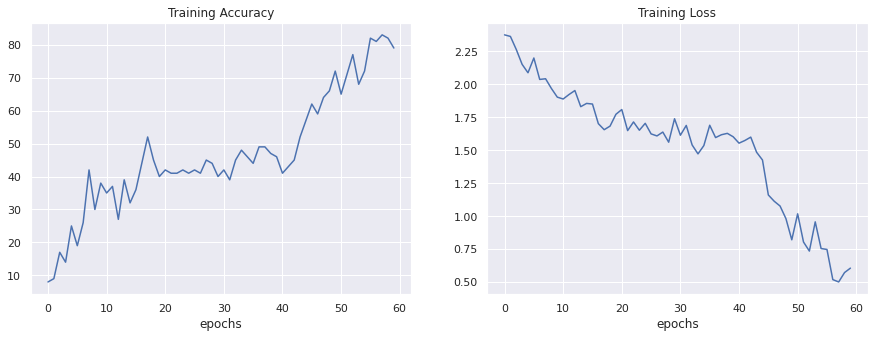

____________________________
Test phase
Test Results :  Loss : 3.1793493852615358 / Accuracy : 29.10999870300293 %


In [ ]:
training('ResNet18', epochs=20, train_loader=train_loader, test_loader=test_loader)

* **Pretrained Resnet-34 model**

- ResNet34
____________________________
Train phase
Train Epoch: 0 : Loss : 2.3794 / Accuracy : 12.0000 %
Train Epoch: 5 : Loss : 2.0737 / Accuracy : 28.0000 %
Train Epoch: 10 : Loss : 1.9864 / Accuracy : 31.0000 %
Train Epoch: 15 : Loss : 1.8243 / Accuracy : 35.0000 %
Train Epoch: 20 : Loss : 1.7626 / Accuracy : 38.0000 %
Train Epoch: 24 : Loss : 1.6981 / Accuracy : 39.0000 %
Train Epoch: 25 : Loss : 1.5879 / Accuracy : 54.0000 %
Train Epoch: 30 : Loss : 1.7425 / Accuracy : 35.0000 %
Train Epoch: 35 : Loss : 1.4939 / Accuracy : 50.0000 %
Train Epoch: 40 : Loss : 1.4340 / Accuracy : 47.0000 %
Train Epoch: 45 : Loss : 1.3974 / Accuracy : 50.0000 %
Train Epoch: 49 : Loss : 1.3630 / Accuracy : 54.0000 %
Train Epoch: 50 : Loss : 1.4876 / Accuracy : 48.0000 %
Train Epoch: 55 : Loss : 1.5042 / Accuracy : 50.0000 %
Train Epoch: 60 : Loss : 1.0970 / Accuracy : 60.0000 %
Train Epoch: 65 : Loss : 0.9072 / Accuracy : 73.0000 %
Train Epoch: 70 : Loss : 0.6463 / Accuracy : 80.0000 %
Train Epoch: 74

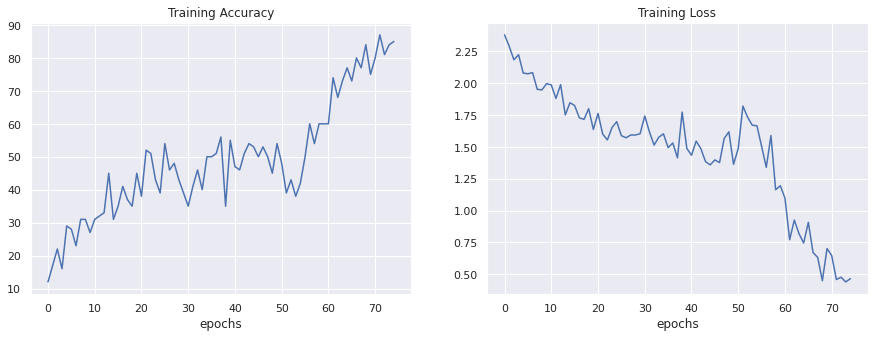

____________________________
Test phase
Test Results :  Loss : 3.0963931488990784 / Accuracy : 30.6299991607666 %


In [ ]:
training('ResNet34', epochs=25, train_loader=train_loader, test_loader=test_loader)

* **Pretrained Resnet-50 model**

- ResNet50
____________________________
Train phase
Train Epoch: 0 : Loss : 2.3436 / Accuracy : 7.0000 %
Train Epoch: 5 : Loss : 2.1714 / Accuracy : 20.0000 %
Train Epoch: 10 : Loss : 2.0238 / Accuracy : 28.0000 %
Train Epoch: 15 : Loss : 1.9946 / Accuracy : 30.0000 %
Train Epoch: 20 : Loss : 1.9140 / Accuracy : 35.0000 %
Train Epoch: 25 : Loss : 1.8001 / Accuracy : 47.0000 %
Train Epoch: 30 : Loss : 1.7341 / Accuracy : 43.0000 %
Train Epoch: 32 : Loss : 1.7001 / Accuracy : 45.0000 %
Train Epoch: 35 : Loss : 1.6871 / Accuracy : 45.0000 %
Train Epoch: 40 : Loss : 1.5695 / Accuracy : 46.0000 %
Train Epoch: 45 : Loss : 1.5919 / Accuracy : 46.0000 %
Train Epoch: 50 : Loss : 1.4667 / Accuracy : 56.0000 %
Train Epoch: 55 : Loss : 1.4082 / Accuracy : 55.0000 %
Train Epoch: 60 : Loss : 1.5626 / Accuracy : 50.0000 %
Train Epoch: 65 : Loss : 1.4483 / Accuracy : 60.0000 %
Train Epoch: 70 : Loss : 1.8379 / Accuracy : 40.0000 %
Train Epoch: 75 : Loss : 1.7293 / Accuracy : 43.0000 %
Train Epoch: 80 

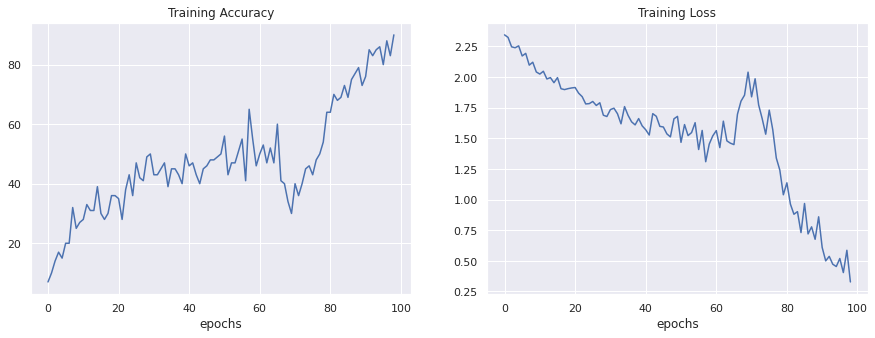

____________________________
Test phase
Test Results :  Loss : 2.6269123691320417 / Accuracy : 33.349998474121094 %


In [ ]:
training('ResNet50', epochs=33, train_loader=train_loader, test_loader=test_loader)

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

**Answer 7:**

In this lab, our goal is to study the behavior of training procedures given a tiny dataset. 

**Choice of the learning procedure:**
<br>
> In this part, we will discuss the learning procedure that we chose to train the chosen models. The training is divided into $3$ parts, where in each part we unfreeze more layers in the architecture. Let's say that we are going to train the model for $60$ epochs:
> * In the first part ($20$ epochs), we froze all the layers and we trained only the fully connected layers. 
> * In the next part ($20-40$ epochs), we froze only the first half of the layers and we trained the model on the other half.
> * Finally, in the last part($40-60$ epochs), we trained the model on all the unfrozen layers.
<br>
> $\Longrightarrow$ We can conclude that this approach gave better results than the classic approach (in case we freeze pretrained model layers and train the added fully connected layers).

**Comparison between ResNet-18 VS Pretrained ResNet-18:**
<br> 
> In this part, we compared the performance of ResNet-18 trained from scratch on our dataset and Pretrained ResNet-18 on ImageNet. 
> * For the ResNet18, we trained the model for $20$ epochs with a batch size equal to $20$. We can clearly notice that the model is overfitting. Indeed, we got a training accuracy of $98 \%$ and a testing accuracy of only $23.92 \%$. The results are unstable when we re-train the model, but this value did not improve even when we vary parameters.
<br>
> * For the Pretrained ResNet-18, we obtained better accuracy ($29.44 \%$ VS $23.92 \%$) on the test data set after training the model for $45$ epochs. 
<br>
> $\Longrightarrow$ We can say that this model is able to capture features that the first model ignored which yielded in better performance.

**Comparison between Pretrained ResNet-18, Pretrained ResNet-34 and Pretrained ResNet-50:** 
<br>
> Here, we tried to explore other versions of the ResNet architecture to see if the new version better solves the difficulties encountered with the small data set. It turns out that complicating the architecture does not necessarily improve the results significantly when dealing with a small data set. The pre-trained ResNet-50 gave a test accuracy of $30.57\%$ after $90$ epochs, while the pre-trained ResNet-18 gave a test accuracy of $29.44\%$ after $45$ epochs when running the model with the original images. Nevertheless, when we used the resized images for training, we obtained higher performance for all models, with the best accuracy $63.11\%$ for ResNet-34.

**Impact of data augmentation:**
<br>
> In order to improve the model performance trained on tiny dataset, the first intuitive idea that comes to mind (after using a pretrained model) is using data augmentation. By applying some of the transformations, explored in Question $5$, we managed to improve the results. For the ResNet-18 trained from scratch, we passed from $23.92\%$ to $30.97\%$. For the pretrained ResNet-18, the model accuracy slightly increased from $30.97\%$ to $31.95\%$. For the pretraiend ResNet-34, we had an improvement of $1.75\%$. As for the pretraiend ResNet-50, we had an improvement of over $3\%$ (from $31.16\%$ to $34.56\%$) which revealed to be the best model in our study.
<br> 
> $\Longrightarrow$ We can say that, when chosen carefully, the data augmentation technique can help obtain good results. However, poorly chosen transformations can lead to disastrous results.



# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

**Answer:**

---

**Title:** Curriculum Labeling (CL) Algorithm.

<img src="https://docs.google.com/uc?export=download&id=18UTYtLmREXhZAJSB1l4fXxC7g5s9MiXn" width="1000" height="250">

**Source:** [Cascante-Bonilla, et al.](https://github.com/uvavision/Curriculum-Labeling)

---






> In this part, we got inspired by the idea of [[Cascante-Bonilla, et al.]](https://github.com/uvavision/Curriculum-Labeling). Their method, "Curriculum Labeling", is based on pseudo-labeling approach which is the process of using a model trained on labeled data to generate pseudo-labels for the unlabeled dataset. Then, the most confident pseudo-labels (regarding a chosen threshold) are added to the labeled dataset. Next, the process is repeated by training a new model from scratch on the combined labeled dataset and generating pseudo-labels to the remaining unlabeled samples. The process stops when the number of labeled samples exceeds half the size of the training dataset in order to reduce the training time. The following algorithm explains in details the approach.

<center> <img src="https://docs.google.com/uc?export=download&id=1y8AeOtkD__I038L10sqSZUe_fLqIx9IZ" width="400" height="350">




> To do so, we used the previous architecture with a baseline model: "Pretrained ResNet-50". We  used the same strategy to train the model (with only first and last stages) with a batch size equal to $20$, a number of epochs equal to $20 \times 2$, the SGD optimizer with a learning rate equal to $10^{-3}$ and a momentum of $0.9$. We fixed the threshold for selecting pseudo-lables equal to $0.85$. <br><br> 
> The following table resumes the evolution of the labeling of the model. We can see that as the number of the labled samples increases after each iteration, the performance of the model increases. The finall model achieved an accuracy of $33.9 \%$ on test data.



| Iterations | Number of total selected lables  | Train accuracy | Test accuracy |
|------|------|------|------|
| 1 | <center> 100 </center> | <center> 99 %<center>| <center>29.15 %<center>|
| 2 |  <center> 3431 </center> | <center> 99.76 %<center> | <center>33.24 %<center> |
| 3 |  <center> 34563 </center> | <center> 98.83 %<center> | <center>**33.9%**<center> |

In [8]:
batch_size = 20

# Loading train data set
all_trainset = torchvision.datasets.CIFAR10(root ="\content",train=True, download =True , transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(all_trainset, shuffle=False, batch_size=batch_size) 

for batch_idx, (data, target) in enumerate(train_loader):
  if batch_idx == 0:
    X = data
  else : 
    X = torch.cat((X, data))  
    
y = all_trainset.targets 

# Loading test data set
all_test = torchvision.datasets.CIFAR10(root ="\content",train =False, download =True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(all_test, shuffle=False, batch_size=batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting \content/cifar-10-python.tar.gz to \content
Files already downloaded and verified


Number of labled samples: 100
____________________________
Train phase
Train Epoch: 0 : Loss : 2.3363 / Accuracy : 11.0000 %
Train Epoch: 5 : Loss : 2.1056 / Accuracy : 32.0000 %
Train Epoch: 10 : Loss : 1.7954 / Accuracy : 51.0000 %
Train Epoch: 15 : Loss : 1.6283 / Accuracy : 65.0000 %
Train Epoch: 19 : Loss : 1.5145 / Accuracy : 63.0000 %
Train Epoch: 20 : Loss : 1.4825 / Accuracy : 60.0000 %
Train Epoch: 25 : Loss : 0.6935 / Accuracy : 90.0000 %
Train Epoch: 30 : Loss : 0.2456 / Accuracy : 97.0000 %
Train Epoch: 35 : Loss : 0.1013 / Accuracy : 100.0000 %
Train Epoch: 39 : Loss : 0.0656 / Accuracy : 99.0000 %
____________________________
Test phase
Test Results :  Loss : 2.1530477359294893 / Accuracy : 29.149999618530273 %
Number of total labled samples: 3431
____________________________
Train phase
Train Epoch: 0 : Loss : 1.2866 / Accuracy : 62.2850 %
Train Epoch: 5 : Loss : 0.5384 / Accuracy : 83.6491 %
Train Epoch: 10 : Loss : 0.4654 / Accuracy : 84.6692 %
Train Epoch: 15 : Loss 

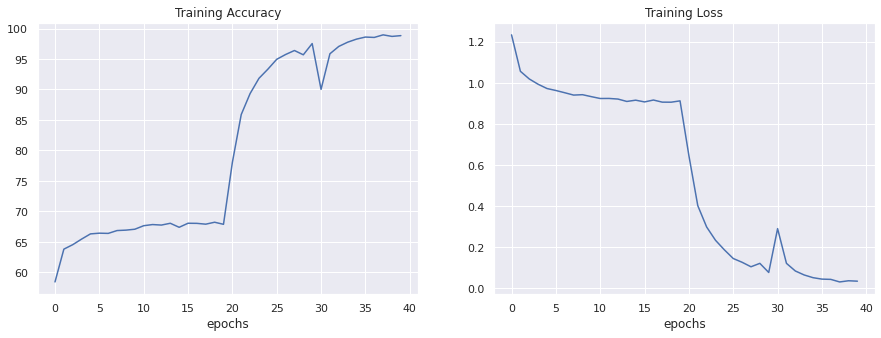

____________________________
Test phase
Test Results :  Loss : 6.731655247688294 / Accuracy : 33.89999771118164 %


In [ ]:
epochs = 20
idx = list(np.arange(100))
y_labled = y[:100]
print('Number of labled samples:', len(idx))

while len(idx) < len(all_trainset)//2:

  # Preparing data
  remaining_idx = list(set(np.arange(len(all_trainset))) - set(idx))
  X_labled = X[idx]
  X_unlabled = X[remaining_idx]

  trainset = torch.utils.data.TensorDataset(torch.tensor(X_labled), torch.tensor(y_labled))
  train_labled_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)  

  trainset_unlabled = torch.utils.data.TensorDataset(torch.tensor(X_unlabled),torch.from_numpy(np.zeros(len(X_unlabled))))
  train_unlabled_loader = torch.utils.data.DataLoader(trainset_unlabled, batch_size=(len(X_unlabled)), shuffle=False)

  # Define the model 
  model = Net('ResNet50')

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
  
  print("____________________________")
  print("Train phase")

  # ----------------- Fine-tune only the last layer of the architecture ------------------ #

  for param in model.parameters():
    param.requires_grad = False

  for param in model.fc.parameters():
    param.requires_grad = True
  
  for param in model.fc1.parameters():
    param.requires_grad = True
  
  train_accuracy , training_loss = train(model,epochs,optimizer, scheduler, criterion,train_labled_loader, start_epoch = 0)

  # ----------------------- Fine-tune the whole architecture ---------------------------- #

  for param in model.parameters():
    param.requires_grad = True 
  train_accuracy1 , training_loss1 = train(model,epochs,optimizer,scheduler,criterion,train_labled_loader,  start_epoch = epochs) 

  print("____________________________")
  print("Test phase")
  test_accuracy = test(model, criterion, device, test_loader)
  
  # ----------------------- Create new labels ---------------------------- #
  with torch.no_grad():
    model.eval()

    for batch_idx, (data, target) in enumerate(train_unlabled_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = torch.max(F.softmax(output,dim=1),dim=1).values.cpu().numpy() 
        keep_idx = np.where(predicted > 0.85)[0]
        new_samples = np.array(remaining_idx)[keep_idx]
        new_lables = (F.softmax(output,dim=1)).argmax(dim=1).cpu().numpy()[keep_idx]

  idx += list(new_samples)
  y_labled += list(new_lables)
  print('Number of total labled samples:', len(idx))

# ----------------------- Last train ---------------------------- # 

# Selecting labled + pseudo labeled samples 
X_labled = X[idx]
trainset = torch.utils.data.TensorDataset(torch.tensor(X_labled), torch.tensor(y_labled))
train_labled_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Define the model 
model = Net('ResNet50')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

print("____________________________")
print("Train phase")

# ----------------- Fine-tune only the last layer of the architecture ------------------ #

for param in model.parameters():
  param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad = True

for param in model.fc1.parameters():
  param.requires_grad = True

train_accuracy , training_loss = train(model,epochs,optimizer, scheduler, criterion,train_labled_loader, start_epoch = 0)

# ----------------------- Fine-tune the whole architecture ---------------------------- #

for param in model.parameters():
  param.requires_grad = True 
train_accuracy1 , training_loss1 = train(model,epochs,optimizer,scheduler,criterion,train_labled_loader,  start_epoch = epochs) 

show(train_accuracy+train_accuracy1 , training_loss+training_loss1) 

print("____________________________")
print("Test phase")
test_accuracy = test(model, criterion, device, test_loader)

---